In [1]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
def capture_image():
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise Exception("Could not capture image")          
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [18]:
def segment_image_two_clusters(image, method="kmeans", downscale=(80, 80), **kwargs):
    h, w, _ = image.shape

    # Downscale for faster processing
    img_small = cv2.resize(image, downscale, interpolation=cv2.INTER_AREA)
    pixels_small = img_small.reshape(-1, 3)

    # Scale features (important for DBSCAN & Agglomerative)
    pixels_scaled = StandardScaler().fit_transform(pixels_small)
    if method == "dbscan":
        model = DBSCAN(eps=0.8, min_samples=50, **kwargs)
        labels = model.fit_predict(pixels_scaled)
    elif method == "agglo":
        model = AgglomerativeClustering(n_clusters=2, **kwargs)
        labels = model.fit_predict(pixels_scaled)
    elif method == "kmeans":
        model = KMeans(n_clusters=2, random_state=42, **kwargs)
        labels = model.fit_predict(pixels_small)  # No scaling needed
    else:
        raise ValueError("Method must be 'dbscan', 'agglo', or 'kmeans'.")
    colors = np.array([
        [255, 255,255], 
        [0, 0, 0],  
        [255, 0, 0]    
    ], dtype=np.uint8)

    seg_small = np.array([colors[label] if label >= 0 else [0, 0, 0] for label in labels])
    seg_small = seg_small.reshape(downscale[1], downscale[0], 3)

    # Resize segmentation to original size
    seg_full = cv2.resize(seg_small, (w, h), interpolation=cv2.INTER_NEAREST)

    return seg_full, labels

In [16]:
image_rgb = capture_image()

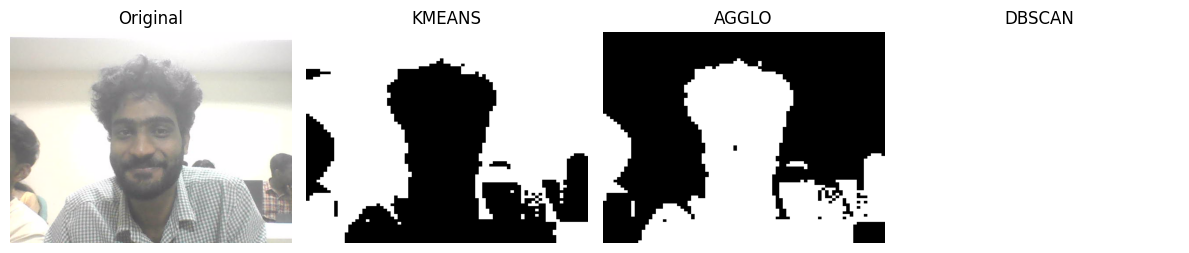

In [19]:
methods = ["kmeans", "agglo", "dbscan"]
plt.figure(figsize=(12, 6))
plt.subplot(1, len(methods)+1, 1)
plt.imshow(image_rgb)
plt.title("Original")
plt.axis("off")

for i, method in enumerate(methods, start=2):
    seg_img, _ = segment_image_two_clusters(image_rgb, method=method, downscale=(80, 80))
    plt.subplot(1, len(methods)+1, i)
    plt.imshow(seg_img)
    plt.title(method.upper())
    plt.axis("off")

plt.tight_layout()
plt.show()